## 실행O 까지 실행 X

In [67]:
import pandas as pd
import numpy as np
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
 
from linearmodels.asset_pricing import LinearFactorModel
 
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from pandas.tseries.offsets import *

#### 1. 주식 가격 데이터 다운로드

In [68]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [ ]:
finance = ['DBC','EMLC','VTI','VWO','EEM','TLT','USO','IEF','VWOB','GLD','DBA','SIVR']
rate = [25,15,10,10,7,7,7,6,4,3,2,2]
start_date = '2010-01-01'

In [78]:
def data_download(finance, start_date):
    price = yf.download(finance,start = start_date)
    price = price['Adj Close'].reset_index()
    max = 0
    ticker = ''
    for i in price:
        if max < price[i].isnull().sum():
            max = price[i].isnull().sum()
            ticker = i
    price = price[price[ticker].notnull()]
    
    #Get all days within the sample period (데이터에 없는 날짜 채우기)
    start_date = price['Date'].astype(str).iloc[0]
    end_date = price['Date'].astype(str).iloc[-1]

    date_all = pd.date_range(start_date, end_date, freq='D').to_frame().rename(columns={0:'Date'}).reset_index(drop=True)

    #Merge with price data (데이터 병합)
    price_all = pd.merge(date_all,price,how='left')
    
    # 원래 데이터에 없는 1월 5일과 6일이 생긴 것을 볼 수 있습니다. 
    # 이제 새로 생긴 NaN 변수에 가격 데이터를 채워줘야 합니다. 
    # 직전 날짜의 가격 데이터를 넣어주면 되므로 다음과 같은 코드를 작성해 줍니다.
    
    #the 'ffill' method propagates last valid observation forward (직전의 유효한 값으로 NaN 값 채우기)
    price_all = price_all.fillna(method='ffill')
    
    #### 3. 월별 수익률 계산 (Calculate weekly returns)
    #Generate end of month data (월말 날짜 생성)
    month_end = pd.date_range(start_date, end_date, freq='M')

    #Get only end of month prices (월말 가격 데이터 생성)
    price_month = price_all[price_all['Date'].isin(month_end)].reset_index(drop=True)

    #Set index and remove the Day Name columns (index 설정 및 Day_Name column 삭제)
    price_month = price_month.set_index(['Date'])

    #Monthly returns (월 수익률)
    month_ret = price_month.pct_change(1).dropna()
    return month_ret

In [79]:
month_ret = data_download(finance, start_date)

[*********************100%***********************]  12 of 12 completed


---

### 포트폴리오 수익률 계산

#### 1. 각 주식의 포트폴리오 비중 계산

In [97]:
#### 2. 가중 평균 함수 작성
# 각 날짜별로 포트폴리오 내에 있는 모든 주식을 가중평균 해야 하므로 .groupby() 메서드를 이용할 것을 감안하여 
# group 매개변수가 들어가며, 평균을 계산할 변수를 avg_name 매개변수로, 가중치를 weight_name 매개변수로 설정합니다.

# Weighted average (가중 평균 수익률 구하는 함수)
def weighted_average(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [96]:
def weight_sum_rate(finance, rate, month_ret):
    invst_money = pd.DataFrame([finance,rate],index = ['Name','Invest']).T
    month_ret = month_ret.stack().reset_index().rename(columns={'level_1':'Name',0:'Ret'}).sort_values(by=['Name','Date'])

    #다음 코드를 이용하여 투자 금액과 수익률 데이터를 합쳐줍니다.
    month_ret_1 = pd.merge(month_ret,invst_money,how='left')
    month_ret_1
    
    # 누적수익률 X 초기 투자비용을 계산하면 각 날짜의 말 값이 나오기 때문에 .shift() 메서드를 이용하여 
    # lag 누적 수익률을 만든 후 초기 투자비용을 곱하여 각 날짜의 초 값으로 만들어 줍니다. 해당 변수의 이름 = wt 
    # .shift() 메서드를 사용할 때 각 주식별로 따로 적용이 되어야 하기 때문에 
    # .groupby() 메서드를 이용하여 계산해 주도록 하겠습니다.
    
    #Portfolio return
    month_ret_1['1+ret'] = month_ret_1['Ret'] + 1
    month_ret_1['cumret'] = month_ret_1.groupby(['Name'])['1+ret'].cumprod()
    month_ret_1['lcumret'] = month_ret_1.groupby(['Name'])['cumret'].shift(1)
    month_ret_1['wt'] = np.where(month_ret_1['lcumret'].isna(), month_ret_1['Invest'], month_ret_1['Invest']*month_ret_1['lcumret'])

    #Buy and hold strategy
    port_ret = month_ret_1.groupby(['Date','Name']).apply(weighted_average, 'Ret','wt').to_frame().reset_index().rename(columns={0: 'vwret'})

    return port_ret

In [100]:
port_ret = weight_sum_rate(finance, rate, month_ret)

In [101]:
port_ret.to_csv('port_ret_2.csv')

---

## 실행O

### 월별 포트폴리오 수익률 계산

In [13]:
import pandas as pd
import numpy as np
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
 
from linearmodels.asset_pricing import LinearFactorModel
 
import matplotlib.pyplot as plt
import seaborn as sns

#### data-loader

In [14]:
ff_portfolio_data = pd.read_csv('port_ret_2.csv',index_col=0)

전체 시장의 초과 기대 수익률(Rm-Rf)을 독립변수로 개별 자산의 기대 수익률(Ri)을 종속변수로 하는 단순 선형 회귀 모형(simple linear regression model)으로 볼 수 있다.

- 파마-프렌치 3 팩터 모델은 CAPM에서 사용한 리스크 원천에 기업의 상대적 규모(relative size)와 가치(value)를 추가한 것이고, 
- 5 팩터 모델은 여기에 기업 이익(firm profitability)과 투자 수준(level of investment)을 포함하여 확장한 것이다. 
- 파마-프렌치 3 팩터 모델은 시장의 초과 수익을 나타내는 베타가 유의한 팩터가 아니며, 그보다는 기업 규모와 가치지표를 사용하는 것이 자산 수익률 예측에 효과적이라는 것을 밝혔다고 한다

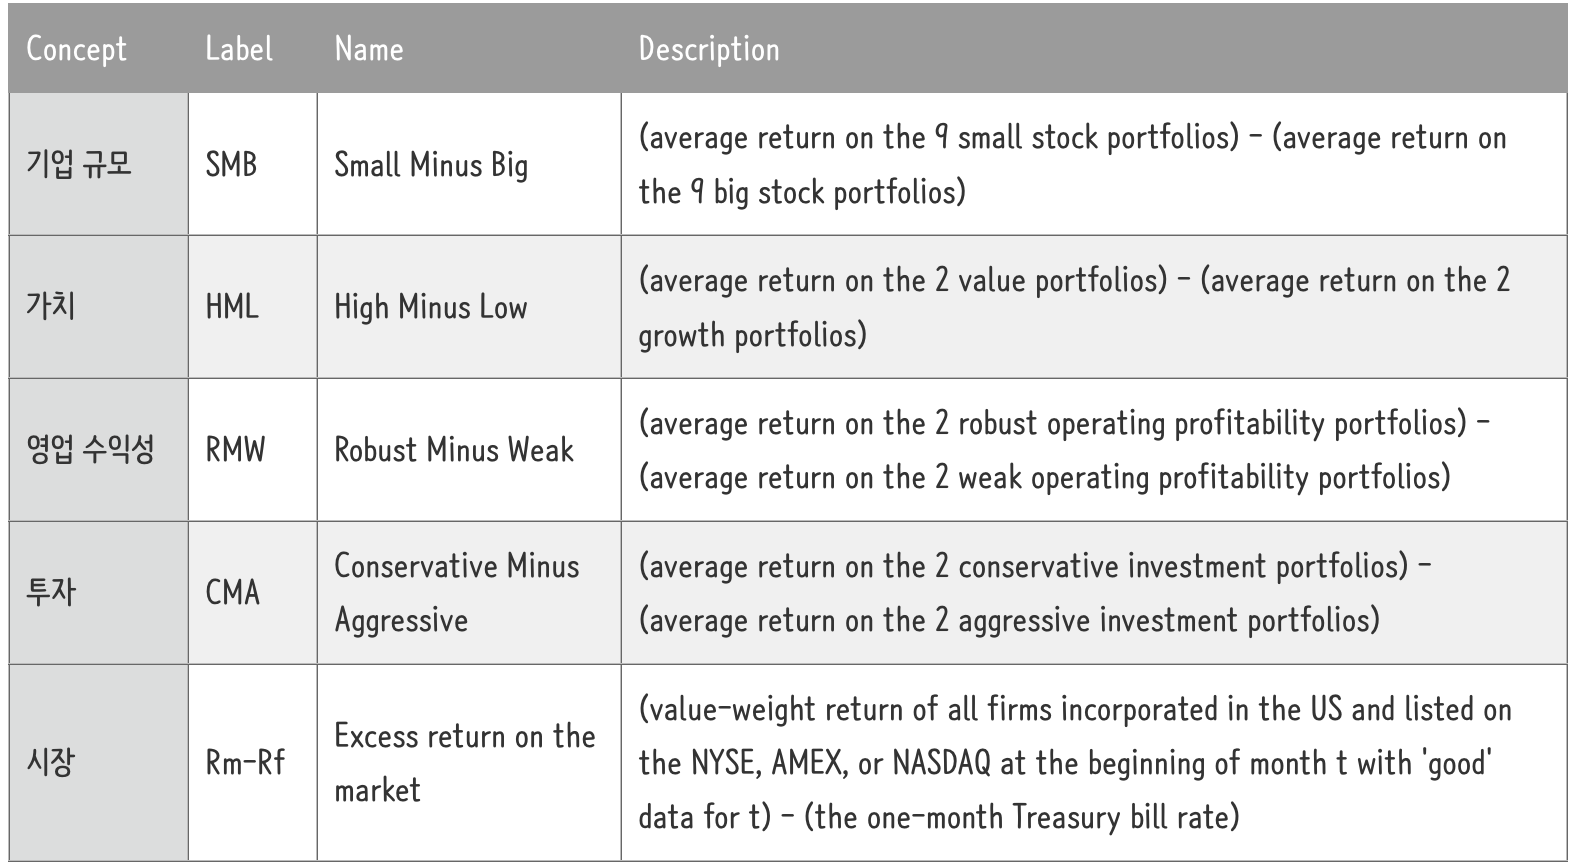

In [15]:
def Factor_model(ff_portfolio_data):
    # 총 기간동안의 월별 수익률 - Factor
    ff_factor = 'F-F_Research_Data_5_Factors_2x3'
    ff_factor_data = web.DataReader(ff_factor, 'famafrench', start=ff_portfolio_data.Date[0])[0]

    # 파마-프렌치 5 팩터 모델
    ff_portfolio_data['Date']=ff_portfolio_data.Date.apply(lambda x: x[:7])
    ff_portfolio_data = ff_portfolio_data[ff_portfolio_data.Date!='2022-10']
    ff_factor_data = ff_factor_data.reset_index()
    ff_factor_data['Date']=ff_factor_data.Date.astype('str')
    ff_factor_data = ff_factor_data.set_index('Date')
    ff_portfolio_data = pd.pivot_table(ff_portfolio_data, values = 'vwret', columns= 'Name', index = 'Date')    
    
    # 포트폴리오 수익률 - 무위험 수익률 = 초과 수익률
    ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)

    # 무위험 수익률 변수를 제외한 5개 팩터 변수만 남김
    ff_factor_data = ff_factor_data.drop('RF', axis=1)
    
    # Step 1: Factor Exposures
    betas = []
    for industry in ff_portfolio_data:
        # 주식 별로 OLS
        step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], # 종속변수 
                    exog=add_constant(ff_factor_data) # 독립변수
                    ).fit()
        betas.append(step1.params.drop('const'))

    betas = pd.DataFrame(betas, 
                         columns=ff_factor_data.columns, 
                         index=ff_portfolio_data.columns)
    
    # Step 2: Risk Premia
    lambdas = []
    for period in ff_portfolio_data.index:
        step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], # 종속변수
                    exog=betas # 독립변수
                    ).fit()
        lambdas.append(step2.params)

    lambdas = pd.DataFrame(lambdas, 
                           index=ff_portfolio_data.index,
                           columns=betas.columns.tolist())
    return ff_portfolio_data, ff_factor_data, lambdas

In [16]:
ff_portfolio_data, ff_factor_data, lambdas = Factor_model(ff_portfolio_data)

In [17]:
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2013-07,5.65,1.80,0.57,-1.35,0.52
2013-08,-2.71,-0.06,-2.69,0.66,-2.16
2013-09,3.77,2.66,-1.22,-0.58,-1.40
2013-10,4.18,-1.51,1.25,2.78,0.92
2013-11,3.13,1.40,0.32,0.14,0.05
...,...,...,...,...,...
2022-05,-0.34,-0.06,8.41,1.44,3.98
2022-06,-8.43,1.30,-5.97,1.85,-4.70
2022-07,9.57,1.88,-4.10,0.68,-6.94


In [18]:
lambdas

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2013-07,1.449176,3.260542,2.558866,-1.135406,1.655692
2013-08,-4.325793,58.432054,-11.470200,-21.777795,11.394276
2013-09,8.845782,-44.162851,4.320565,14.969567,-7.480531
2013-10,7.352504,-14.184765,-3.651793,3.358236,-0.530843
2013-11,3.461426,-9.343785,-1.641062,-0.771020,-4.181072
...,...,...,...,...,...
2022-05,-2.342811,0.523102,4.816680,-3.252795,-4.270677
2022-06,-3.905393,-4.996469,-6.433707,-7.848184,-3.023961
2022-07,5.011711,0.779258,-12.804930,-8.353352,-10.542184


In [6]:
# Fama-MacBeth 5 factor model
lambdas.mean()

Mkt-RF    1.184119
SMB      -3.213143
HML      -4.743783
RMW      -6.732837
CMA       0.397241
dtype: float64

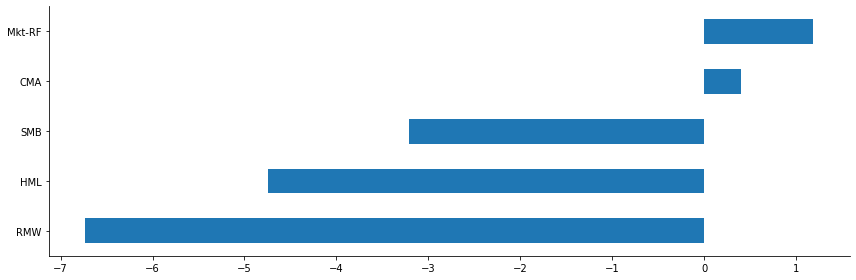

In [7]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout()

- 아래는 2단계 추정의 결과로 산출된 계수 값들을 2년 단위로 이동평균을 계산하여 그래프를 그린 것이다. 계수 추정치가 시간의 흐름에 따라 크게 변하지는 않는지 확인하기 위한 것으로 보면 된다.

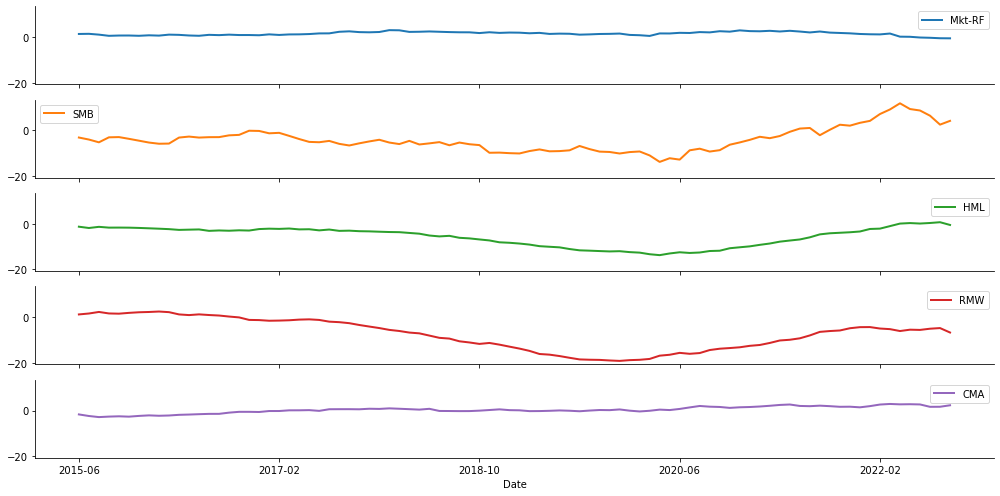

In [8]:
window = 24  # year
lambdas.rolling(window).mean().dropna().plot(lw=2,
                                             figsize=(14, 7),
                                             subplots=True,
                                             sharey=True)
sns.despine()
plt.tight_layout()

- LinearModels 라이브러리는 statsmodels 라이브러리를 확장하여 패널 데이터를 다루기 위한 다양한 모델을 제공하고 파마-맥베스 회귀 모형도 제공한다. 위에서 2-step으로 직접구현한 결과와 동일한 계수 추정치를 얻을 수 있다.

In [9]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.2286
No. Factors:                          5   J-statistic:                    47.845
No. Observations:                   111   P-value                         0.0000
Date:                  Wed, Nov 09 2022   Distribution:                  chi2(7)
Time:                          14:53:33                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.1841     2.1103     0.5611     0.5747     -2.9521      5.3203
SMB           -3.2131     15.120    

- 파마-맥베스의 연구에서는 시장의 초과 수익률 베타의 효과가 없고 사이즈(SMB), 가치(HML) 팩터의 효과가 있다는 것을 보여주었는데, 분석 기간의 차이로 인한 것인지 우리의 결과에서는 Mkt-RF는 유의한 팩터이고, SMB, HML, RMW은 유의하지 않은 팩터로 나타났다. 
- Mkt-RF와 CMA만 유의한 팩터로 나타났는데, 영업이익이 꾸준하게 나오고 모멘텀이 좋은(Mkt-RF는 모멘텀 팩터로 볼 수 있다고 함) 자산에 투자하는 것이 좋다라고 해석해볼 수 있을 것 같다. 
- 이렇게 분석 기간에 따른 차이 효과를 보정하기 위해 여러 기간의 데이터를 섞어서 백테스팅을 하는 경우가 많다고 한다.


- full_summary를 프린트해보면 각각의 주식에 대한 계수 추정치가 나오는데 주식별로 유의한 팩터들이 다르게 나타나는 것을 볼 수 있다.

In [10]:
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 12   R-squared:                      0.2286
No. Factors:                          5   J-statistic:                    47.845
No. Observations:                   111   P-value                         0.0000
Date:                  Wed, Nov 09 2022   Distribution:                  chi2(7)
Time:                          14:53:33                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.1841     2.1103     0.5611     0.5747     -2.9521      5.3203
SMB           -3.2131     15.120    